# Importing Modules

In [1]:
import torch
import torchinfo
import torchvision

import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
import models

In [3]:
import importlib
importlib.reload(models)

<module 'models' from 'c:\\Users\\josep\\Code\\School\\RL\\Project\\src\\models\\__init__.py'>

# Configure

In [4]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)


In [5]:
device

device(type='cuda')

In [7]:
def save_model(agent, path: str):
    """Save DQN model weights"""
    torch.save({
        'policy_net_state_dict': agent.policy_net.state_dict(),
        'target_net_state_dict': agent.target_net.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
    }, path)
    print(f"Model saved to {path}")

def load_model(agent, path: str):
    """Load DQN model weights"""
    checkpoint = torch.load(path)
    agent.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
    agent.target_net.load_state_dict(checkpoint['target_net_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model loaded from {path}")
    return agent

# Hyperparameters search

In [8]:
search = models.GridHyperparameterSearch()
best_config, results_df = search.run_search()

Testing 324 configurations...


 39%|███▉      | 127/324 [7:24:09<11:28:58, 209.84s/it]


KeyboardInterrupt: 

In [55]:
import pandas as pd
results_df = pd.DataFrame(search.results)
results_df = results_df.sort_values('eps_to_converge', ascending=True)

In [56]:
best = results_df.iloc[0].drop(["eps_to_converge"]).to_dict()
best["memory_size"]
print(best)

{'n_epochs': 1000.0, 'batch_size': 128.0, 'epsilon_start': 0.9, 'epsilon_min': 0.05, 'epsilon_decay': 1000.0, 'tau': 0.01, 'gamma': 0.99, 'learning_rate': 0.01, 'memory_size': 10000.0}


In [ ]:
best = {'n_epochs': 1000.0, 'batch_size': 128.0, 'epsilon_start': 0.9, 'epsilon_min': 0.05, 'epsilon_decay': 1000.0, 'tau': 0.01, 'gamma': 0.99, 'learning_rate': 0.01, 'memory_size': 10000.0}

In [57]:
N_EPOCHS = int(best["n_epochs"])
BATCH_SIZE = int(best["batch_size"])
EPSILON_START = best["epsilon_start"]
EPSILON_MIN = best["epsilon_min"]
EPSILON_DECAY = int(best["epsilon_decay"])
TAU = best["tau"]
GAMMA = best["gamma"]
LR = best["learning_rate"]
MEM_SIZE = int(best["memory_size"])
MODEL_PATH = './best_model.pth'

# Create Environment

In [58]:
env = gym.make("CartPole-v1")
env.reset()

(array([ 0.02715907, -0.04523319, -0.02692717,  0.01651349], dtype=float32),
 {})

# Create Agent

In [59]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = models.CartPoleAgent(env, state_dim, action_dim, device, 
                            memory_size=int(MEM_SIZE), batch_size=int(BATCH_SIZE), 
                            epsilon_start=EPSILON_START, epsilon_min=EPSILON_MIN, epsilon_decay=EPSILON_DECAY, 
                            tau=TAU, gamma=GAMMA, learning_rate=LR)

# Train

In [60]:
# Train the agent
episodes = []
tr_info = models.train(env, agent, device, int(N_EPOCHS))


  1%|          | 6/1000 [00:00<00:22, 44.16it/s, episode_id=5, total_r=16]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

# Plot result

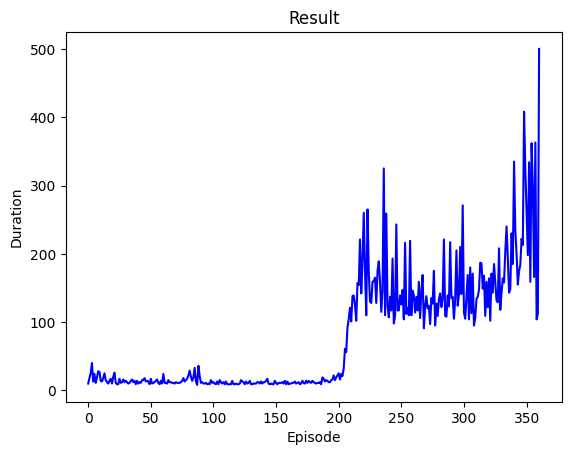

In [11]:
plt.figure(1)
plt.title('Result')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(tr_info['total_r'], color='b')
plt.show()